In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp 
import scipy.stats as st
import seaborn as sns
from collections import Counter
from scipy.stats import poisson

### czy średnia ilośc ataków dla X jest taka sama jak dla Y
#### czy liczba morderstw z użyciem broni palnej w Ameryce Północnej jest taka sama jak w Ameryce środkowej i na Karaibach z użyciem broni białej

In [5]:
df=pd.read_csv('clean_data.csv')

In [7]:
data = df.loc[df["region_txt"].str.contains('Europ', case=False)]

In [12]:
info=data.groupby(['iyear','weapon'])['nkill'].agg(['sum'])

In [13]:
info

sum
iyear weapon                                                  
1970  Chemical                                             0.0
      Explosives                                          52.0
      Firearms                                            15.0
      Incendiary                                          12.0
1971  Explosives                                          49.0
...                                                        ...
2017  Incendiary                                           2.0
      Melee                                               30.0
      Other                                                0.0
      Sabotage Equipment                                   0.0
      Vehicle (not to include vehicle-borne explosive...  21.0

[252 rows x 1 columns]

In [8]:
data['nkill'].sum()

14066.0

In [34]:
x=data.loc[(data['weapon']=='Firearms')&(data['iyear']==1970),['nkill']]            

In [35]:
y=data.loc[(data['weapon']=='Explosives')&(data['iyear']==1971),['nkill']]               

#### stworzenie historgramów, aby sprawdzić jakie sa rozkłady

In [36]:
X=pd.DataFrame.to_numpy(x) 

In [37]:
Y=pd.DataFrame.to_numpy(y) 

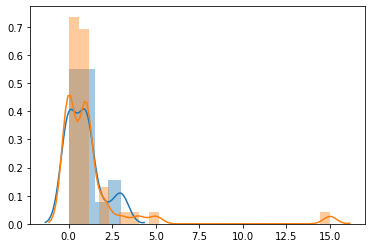

In [38]:
sns.distplot(X)
sns.distplot(Y)

In [66]:
#przy takich danych korzystamy z zmiennych dyskretnych (zmienne losowe)

In [81]:
dictionary=x.groupby(['nkill'])['nkill'].sum()

In [84]:
dictionary.to_dict()

{0.0: 0.0, 1.0: 7.0, 2.0: 2.0, 3.0: 6.0}

### stworzenie zmiennych dyskretnych

In [39]:
lista_x=list(pd.unique(pd.Series(x['nkill'])))

In [78]:
dict_x=Counter(lista_x)

In [86]:
discrite_x = pd.DataFrame.from_dict(dictionary)

In [95]:
discrite_x.rename(columns={'nkill':'suma'},inplace=True)

In [96]:
discrite_x.reset_index(level=0, inplace=True)

In [108]:
discrite_x['density']=discrite_x['suma']/sum(discrite_x['suma'])

In [109]:
discrite_x

,nkill,suma,density
0,0.0,0.0,0.000000
1,1.0,7.0,0.466667
2,2.0,2.0,0.133333
3,3.0,6.0,0.400000


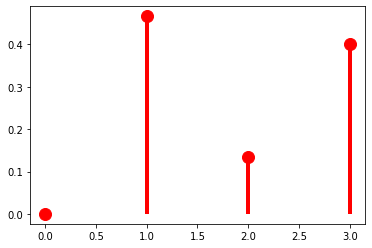

In [110]:
xk = discrite_x['nkill']
pk = discrite_x['density']
custm = st.rv_discrete(name='custm', values=(xk, pk))

fig, ax = plt.subplots(1, 1)
ax.plot(xk, custm.pmf(xk), 'ro', ms=12, mec='r')
ax.vlines(xk, 0, custm.pmf(xk), colors='r', lw=4)
plt.show()

### na podstawie wykresów zmiennych dyskretnych stwierdzono:
* zmienne losowe
* podlegają prawu rzadkich zdarzeń
* zmienne nie są zależne od czasu, który minoł pomiędzy nimi 

#### SPRAWDZENIE CZY ROZKŁĄDY SĄ NORMLANE

In [50]:
x_normed = X / X.max(axis=0)

In [51]:
y_normed = Y/ Y.max(axis=0)

In [52]:
#z = np.concatenate((x_normed, y_normed))
k2, p = st.normaltest(y_normed)
alpha = 0.05
print("p_value = {}".format(p))

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("dane nie podlegają rozkładfowi normalnemu")
else:
    print("dane podlegają rozkładowi normalnem")

p_value = [1.46388031e-16]
dane nie podlegają rozkładfowi normalnemu


In [67]:
#rozkłady nie są normalne dlatego też nie t-student ale sprawdzane czy dsne podlegają rozkładowi Poissona

### jeżeli rozkłąd nie jest normlany to sprawdzenie czy dane podlegają rozkładowi Poissona

In [57]:
mu=np.mean(x['nkill'])
mean, var, skew, kurt = poisson.stats(mu, moments='mvsk')

In [58]:
#kw-> kwartyl
kw = np.arange(poisson.ppf(0.01, mu),
              poisson.ppf(0.99, mu))
ax.plot(kw, poisson.pmf(kw, mu), 'bo', ms=8, label='poisson pmf')
ax.vlines(kw, 0, poisson.pmf(kw, mu), colors='b', lw=5, alpha=0.5)

In [59]:
#sprawdzenie czy dane podlegają rzkłądowi POissona (szczególny przypadek rozkładu dwumianowego)
prob = poisson.cdf(kw, mu)
np.allclose(kw, poisson.ppf(prob, mu))

True

In [113]:
# zmienne podlegają rozkładowi Poissona, da sprawdzenia hipotezy 0 test t-Welcha, jeżeli rozkłąd nie jest normalny

### test zgodności t-welcha dla 2ch próbek -> czy średnia(parametr rozkładu) jest identyczna w porównywanych próbkach

In [67]:
n1=len(X)
n2=len(Y)
rvs1 = st.norm.rvs(size=n1, loc=0., scale=1)
rvs2 = st.norm.rvs(size=n2, loc=0., scale=1)
st.ttest_ind(rvs1,rvs2)
st.ttest_ind(rvs1,rvs2, equal_var = False)

Ttest_indResult(statistic=0.5771100413890139, pvalue=0.5679244967414905)

In [70]:
rvs3 = st.norm.rvs(loc=0, scale=2, size=n1)
print(st.ttest_ind(rvs1, rvs3))

print(st.ttest_ind(rvs1, rvs3, equal_var = False))

Ttest_indResult(statistic=-0.8737479156717906, pvalue=0.3887657334095881)
Ttest_indResult(statistic=-0.8737479156717904, pvalue=0.3897543834480711)


In [55]:
# dla rvs1, rvs2 p val<0,05 -> czyli rozkłądy są do siebie zbliżone
#dla rvs1, rvs3 p val>0,05 -> co to oznacza
#oraz co to zonacza w sytuacji odwrotnej
#co tak naprawde daje mi rvs-> widzę, że jest on zwraca losowe dane z próby ale nie rozumiem, jak to działa tutaj

###  możesz obliczyć sumę różnic w ilości obserwacji: robisz histogram i obliczasz o ile różnią się wysokości słupków

67.39999999999999


674.0

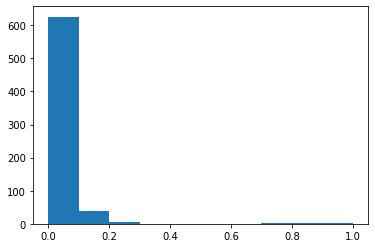

In [113]:
fig = plt.figure()
ax = fig.add_subplot(111)
pdf, bins, patches = ax.hist(x_normed)
print (np.sum(pdf * np.diff(bins)))
np.sum(n1 * np.diff(bins))

In [74]:
results, edges = np.histogram(X, normed=True)
binWidth = edges[1] - edges[0]

/home/paulina_cieslinska/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """Entry point for launching an IPython kernel.


In [114]:
a=results*binWidth

In [83]:
results, edges = np.histogram(Y, normed=True)
binWidth = edges[1] - edges[0]
b=results*binWidth

[0.93548387 0.0483871  0.         0.         0.         0.
 0.         0.         0.         0.01612903]


/home/paulina_cieslinska/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """Entry point for launching an IPython kernel.


In [115]:
df_a = pd.DataFrame(a)  
df_b = pd.DataFrame(b)  

In [93]:
compare=df_a.merge(df_b, left_index=True, right_index=True)

In [116]:
compare['|delta|']=abs(compare['0_x']-compare['0_y'])
compare['%']=abs((compare['0_x']-compare['0_y'])/compare['0_x'])

In [117]:
compare #jaka jest tego interpretacja, że jeżeli %<=5% to mała odchyłka pomiarów pomiędzy sobą i ilośc w tym przypadku średnia ilość morderst danego rodzaju nie odbiega więcej niż 5% 

,0_x,0_y,|delta|,%
0,0.928783,0.935484,0.006700,0.007214
1,0.057864,0.048387,0.009476,0.163772
2,0.007418,0.000000,0.007418,1.000000
3,0.000000,0.000000,0.000000,NaN
4,0.000000,0.000000,0.000000,NaN
5,0.000000,0.000000,0.000000,NaN
6,0.000000,0.000000,0.000000,NaN
7,0.001484,0.000000,0.001484,1.000000
8,0.001484,0.000000,0.001484,1.000000
9,0.002967,0.016129,0.013162,4.435484
